In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import os.path as osp
from PIL import Image
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import cv2
from tqdm import tqdm
from pytorch_msssim import ssim

In [8]:
import re
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [9]:
class Data(D.Dataset):
    def __init__(self, path_mask, path_gt, start_ind = 0, end_ind = 5000):
        super(Data, self).__init__()
        self.masked = []
        self.gt = []
        self.path_mask = path_mask
        self.path_gt = path_gt
        self.transform = transforms.Compose([transforms.ToTensor()])
        files_mask = sorted(glob.glob(os.path.join(path_mask, '*.jpg')), key=numericalSort)[start_ind:end_ind]
        files_gt = sorted(glob.glob(os.path.join(path_gt, '*.jpg')), key = numericalSort)[start_ind:end_ind]
        for mask, gt in  zip(files_mask, files_gt):
            self.masked.append(mask)
            self.gt.append(gt)
        self.len = len(self.masked)
        
    def __getitem__(self, index):
        img_masked = Image.open(self.masked[index])
        img_gt = Image.open(self.gt[index])
        return self.transform(img_masked), self.transform(img_gt)
    
    def __len__(self):
        return self.len
        

In [10]:
path_mask = '/home/sghosal/Project/Image_Inpainting/data_places_mask/'
path_gt = '/home/sghosal/Project/Image_Inpainting/data_places_gt/'
train_imgs = Data(path_mask, path_gt)
val_imgs = Data(path_mask, path_gt, 5000, 7000)

torch.Size([3, 256, 256])


tensor(1.)

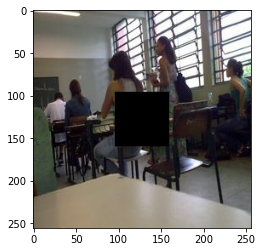

In [11]:
def imshow(img):
    img = img.transpose(0,2).transpose(0,1).numpy()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # Checking that I acutally have the pics associated
# i = np.random.randint(0,len(imgs))
sample = train_imgs[0]
x, y = sample
print(x.shape)
imshow(x)
torch.max(x)

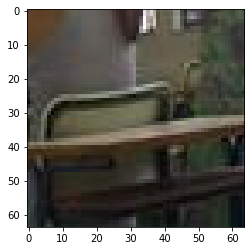

In [12]:
imshow(y[:,96:96 + 64, 96:96+64])

In [13]:
train_loader = D.DataLoader(train_imgs, batch_size = 32, shuffle = True, num_workers = 0)
val_loader = D.DataLoader(val_imgs, batch_size = 32, shuffle = False, num_workers = 0)

In [14]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel, stride = 1, padding = 2, downsample = False, batch_norm = False):
        super(ResBlock, self).__init__()
        self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel , stride, padding)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel , stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)
        self.relu = nn.ReLU()
        self.BN1 = nn.GroupNorm(out_channel//8, out_channel)
        self.BN2 = nn.GroupNorm(out_channel//8, out_channel)
        if downsample :
            if batch_norm:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel, 1, stride = 2), 
                                              nn.GroupNorm(out_channel//8, out_channel))
            else:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel, 1, stride = 2))
        elif in_channel != out_channel:
            if batch_norm:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel,kernel,stride,padding), 
                                          nn.GroupNorm(out_channel//8, out_channel))
            else:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel,kernel,stride,padding))
                
        else:
            if batch_norm:
                self.shortcut = nn.Sequential(nn.GroupNorm(in_channel//8, in_channel))
            else:
                self.shortcut = nn.Sequential()
                
        if batch_norm:
            self.res_block = nn.Sequential(self.conv_1, self.BN1, self.relu, self.conv_2, self.BN2, self.relu)
        else:
            self.res_block = nn.Sequential(self.conv_1,  self.relu, self.conv_2,  self.relu)
        
    def forward(self, x):
        
        output = self.res_block(x)
#         print(f'output shape : {output.shape}')
#         print(f'shortcut shape : {output.shape}')
        return output + self.relu(self.shortcut(x))

In [16]:
class VAE_ResNet(nn.Module):
    def __init__(self, num_latent, batch_norm = True):
        super().__init__()
        
        #So here we will first define layers for encoder network (VGG_16)
        self.conv_1 = nn.Conv2d(3, 64, 7, stride = 2, padding = 3)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.max_pool_1 = nn.MaxPool2d(2, 2)
        self.conv_2x = ResBlock(64,64,kernel=3, stride=2,padding=1, batch_norm = batch_norm, downsample = True)
        self.conv_3x = ResBlock(64,128,kernel=3,stride=1,padding=1, batch_norm= batch_norm)
        self.conv_4x = ResBlock(128,256,kernel=3,stride=2,padding=1, batch_norm= batch_norm, downsample = True)
        self.conv_5x = ResBlock(256,256,kernel=3,stride=2,padding=1, batch_norm= batch_norm, downsample=True)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(4,2)
        if batch_norm:
            self.encoder = nn.Sequential(self.conv_1, self.max_pool_1, nn.GroupNorm(8,64) ,self.relu, self.conv_2x, 
                                      self.conv_3x, self.conv_4x, self.conv_5x, self.maxpool)
        else:
            self.encoder = nn.Sequential(self.conv_1, self.max_pool_1,self.relu, self.conv_2x, 
                                      self.conv_3x, self.conv_4x, self.conv_5x, self.maxpool)
                                    

        
        #These two layers are for getting logvar and mean
        self.fc1 = nn.Linear(3*3*256, 500)
        self.mean = nn.Linear(500, num_latent)
        self.var = nn.Linear(500, num_latent)
        
        #######The decoder part
        #This is the first layer for the decoder part
        self.expand = nn.Linear(num_latent, 500)
        self.fc4 = nn.Linear(500, 3*3*256) # this represents a 8*8*256 cube
        self.decoder = nn.Sequential(nn.ConvTranspose2d(256, 128, 7, stride=2, padding=1), # 15*15*128
                                     nn.GroupNorm(8,128),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(128, 64, 7,stride=2, padding = 4), # 41*41*64
                                     nn.GroupNorm(8,64),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(64, 32, 5, stride=2, padding = 1),  # 85*85*32
                                     nn.GroupNorm(4,32),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(32, 3, 6, stride=2, padding = 1),    # 89*89*16
                                     nn.GroupNorm(1,3),
                                     nn.LeakyReLU(True))

        
    def enc_func(self, x):
        #here we will be returning the logvar(log variance) and mean of our network
        x = self.encoder(x)
#         print(f'shape after resnet : {x.shape}')
        x = x.view([-1, 3*3*256])
        x = self.fc1(x)

        
        mean = self.mean(x)
        logvar = self.var(x)
        return mean, logvar
    
    def dec_func(self, z):
        #here z is the latent variable state
        z = self.expand(z)
        z = self.fc4(z)
        z = z.view([-1, 256, 3, 3])
        
        out = self.decoder(z)
        out = torch.sigmoid(out)
        return out
    
    def get_hidden(self, mean, logvar):
        std = torch.exp(0.5*logvar)   # get std
        noise = torch.randn_like(mean)   # get the noise of standard distribution
        return noise.mul(std).add_(mean)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight())
                
            

    
    def forward(self, x):
        mean, logvar = self.enc_func(x)
        z = self.get_hidden(mean, logvar)
        out = self.dec_func(z)
        # print(out.shape)
        return out, mean, logvar

def VAE_loss(x_recon, y, mean, logvar):
    ### MSE
    base_loss = nn.MSELoss()
#     print(f'shape of reconstructed image : {x_recon.shape}')
    loss = base_loss(x_recon, y[:,:,96:160,96:160])

    # Scale the following losses with this factor
    scaling_factor = x_recon.shape[0]*x_recon.shape[1]*x_recon.shape[2]*x_recon.shape[3]
    
    #### define the KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.05 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    kl_loss /= scaling_factor   # trying without this values
    
    return loss + kl_loss



In [ ]:
def train(trainloader, start_epochs, epochs, model, device, optimizer, avg_losses):
    if len(avg_losses) > 1:
        avg_losses = avg_losses
    else:
        avg_losses = []
    ### Training
    for epoch in tqdm(range(start_epochs+1, epochs+1)):
        start = time.time()
        model.train()
        model.to(device)
        train_loss = 0
        for i,(images, target) in tqdm((enumerate(trainloader))):
            images = images.to(device)
            target = target.to(device)
           
            optimizer.zero_grad()
            out, mean, logvar = model(images)
            out = out.to(device)
#             print(f'shape of out : {out.shape}') 
            # VAE loss
            loss = VAE_loss(out, target, mean, logvar)

            # Backpropagation and optimization
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if epoch %2 == 0:
                torch.save(model.state_dict(), './context_vae.pt')
                torch.save({
                    'epochs': epochs,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'average losses' : avg_losses
                    }, 'checkpoint-{}-1500.pth.tar'.format(epochs))

        ### Statistics   
        avg_losses.append(train_loss/len(trainloader))
        end = time.time()  
        elasped_time = (end - start)/60          
        print('=======> Epoch: {} Average loss: {:.6f}'.format(epoch, train_loss / len(train_loader)))
        print("=======> This epoch took {:.3f} mins to be completed".format(elasped_time))
        
        
    # Plotting the loss function
    plt.plot(avg_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    ### Saving the model
   


# Setting all the hyperparameters
epochs = 10
num_latent = 2000

# model = AlexNet(num_latent)
model = VAE_ResNet(num_latent, True)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Just for the first run
start_epochs = 0
avg_losses = []

# Loading the model
checkpoint = torch.load('./models/VAE_ResNet/checkpoint-100.pth.tar')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epochs = checkpoint['epochs']
avg_losses = checkpoint['average losses']
# print(start_epochs)
### Resume the training
train(train_loader,start_epochs, epochs, model, device, optimizer, avg_losses)

Text(0, 0.5, 'Loss')

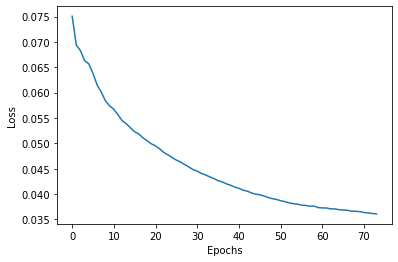

In [12]:
plt.plot(avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [14]:
def imshow_again(img):
    img = img.transpose(0,2).transpose(0,1).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

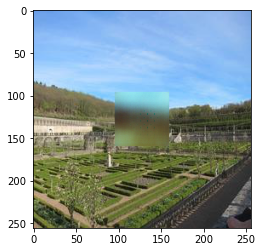

In [29]:
model= VAE_ResNet(2000)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model= model.to(device)
model.load_state_dict(torch.load('./models/VAE_ResNet/checkpoint-50.pth.tar')['model_state_dict'])
model.eval()
with torch.no_grad():
    for i,(x,y) in enumerate(val_loader):
        count +=1
        test = x
        gt = y
        out2,_,_ = model(x.to(device))
        for j in range(10):
            x[j][:,96:160,96:160] = out2[j]
            img = imshow_again(x[j].detach())
            plt.imshow(img)
        break

In [26]:
model.eval()
with torch.no_grad():
    acc_val = []
    for i,(x,y) in tqdm(enumerate(val_loader)):
        test = x
        gt = y
        out2,_,_ = model(x.to(device))
        for j in range(len(x)):
            x[j][:,96:160,96:160] = out2[j]
            loss = (x[:,:,96:160,96:160] - y[:,:,96:160,96:160]) ** 2 
            loss = torch.sum(loss)/32
            acc_val.append(loss)
            
with torch.no_grad():
    acc_train = []
    for i,(x,y) in tqdm(enumerate(train_loader)):
        test = x
        gt = y
        out2,_,_ = model(x.to(device))
        for j in range(len(x)):
            x[j][:,96:160,96:160] = out2[j]
            loss = (x[:,:,96:160,96:160] - y[:,:,96:160,96:160]) ** 2 
            loss = torch.sum(loss)/32
            acc_train.append(loss)
    

63it [01:26,  1.37s/it]
157it [03:39,  1.40s/it]


In [27]:
sum(acc_val)/len(acc_val)

tensor(1769.0293)

In [28]:
sum(acc_train)/len(acc_train)

tensor(1725.1140)